# Final Capstone Project: Analyzing Venue Information based on Urban Index Values

## Introduction and Business Problem

In this analysis the problem being examined is the one of urban vs. rural areas and the types of venues that might be successful in each. Imagine that a development company has several tracts of recently zoned farmland, but also recently acquired some vacant lots in a re-emerging area of a large city. What types of venues are common in the rural areas that might do well on the farmland? What types of venues are popular in the urban downtowns of populous places? How could someone find out what is already out there? 

Using a publicly available dataset from FiveThirtyEight (https://github.com/fivethirtyeight/data/tree/master/urbanization-index), it is possible to examine latitudes and longitudes by state, and also by what the people at FiveThirtyEight are calling the "urbanization index." This is a measure of how many people are living in a 5-mile radius of other people using census data. This is a desireable data set because it already contains latitude and longitude information, in addition to the state name, and will give the rankings of urban vs. rural that the analysis is trying to answer.

Then, using FourSquare venue information, the analysis will examine what types of venues exist based on the urban index of the location, and the data will finally be visualized in a way that is easy to understand and useful in answering the question, what should we build? 


## Data 

There will be 2 types of data used in this analysis. The first is the publicly available dataset from FiveThirtyEight, as previously described in the Introduction. This data set was chosen for many reasons. It contains the latitude and longitude of the locations, which is useful, as I found difficulty in pulling the geotagged data previously and was looking for a data set that included it already. It can be downloaded as a .csv file, a format that is easily integrated with Python into dataframes and then used for analysis. It also was a good resource and really the inspriration for my idea of looking at venue types for urban vs. rural environments, as the prime use of the data set is the "urbanization index" that allows the locations to be classified by population density. 

I plan to sort the data into one state, and then likely choose 5 or 10 random locations within that state that evenly represent urban and rural extremes. I want to make sure that the "suburban" areas are not included, so I will limit the choices in location to the ends of the index. I will probably have to check some of the more rural areas to make sure there is adequate fourquare data, and also run some preliminary analysis and visualization to find the bounds of what I will consider a "rural" value on the index, and what is "urban." 

Once I have the locations chosen, I will pull the venue information from Foursquare, and analyze it to determine the number and types of locations in the rural areas vs the urban. I plan to also gather some of the rating information for the venues to help any potential developer understand the potential success of different venues. I have not yet decided what type of visualization might be best for this, but it will likely involve a map showing the venues and locations, and a graph or table showing the types in each environment. And that will be the finished product.

## Pulling in urban index table

In the following cell I am using IBM code to pull in the .csv file containing the urban index data from FiveThirtyEight. This automatically puts the data into a pandas dataframe that I can manipulate to get the data I need. 

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

#This code contained sensitive information about ibm credentials and will not be included in the final shared notebook. 

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,statefips,state,gisjoin,lat_tract,long_tract,population,adj_radiuspop_5,urbanindex
0,1,Alabama,G0100010020100,32.47718,-86.49007,1845,44076.0,10.69367
1,1,Alabama,G0100010020200,32.47425,-86.47337,2172,43008.0,10.66914
2,1,Alabama,G0100010020300,32.47543,-86.46019,3385,38987.0,10.57098
3,1,Alabama,G0100010020400,32.47200,-86.44363,4267,43131.0,10.67200
4,1,Alabama,G0100010020500,32.45883,-86.42266,9965,43131.0,10.67200


## Adding in other libraries needed to process urban index data

In [4]:
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import geocoder
from geopy.geocoders import Nominatim
print('Libraries imported.')

Libraries imported.


In [2]:
pip install folium

     |████████████████████████████████| 94 kB 3.7 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geocoder

     |████████████████████████████████| 98 kB 6.5 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Cleaning up the urban index data

I am going to examine data from my home state of Ohio. So the first step is getting rid of all the data that is not pertaining to the state of Ohio. 

In [5]:
df_Ohio = df_data_1[df_data_1['state']=='Ohio']
df_Ohio.head()

,statefips,state,gisjoin,lat_tract,long_tract,population,adj_radiuspop_5,urbanindex
50023,39,Ohio,G3900010770100,38.95705,-83.35256,4493,701.5263,6.553258
50024,39,Ohio,G3900010770200,38.98275,-83.54929,4998,1151.1370,7.048505
50025,39,Ohio,G3900010770300,38.84060,-83.58295,7133,2701.5280,7.901573
50026,39,Ohio,G3900010770400,38.77373,-83.53587,4149,2701.5280,7.901573
50027,39,Ohio,G3900010770500,38.75594,-83.35669,3567,792.3294,6.674977


In [6]:
#taking a look at how much data that leaves me
df_Ohio.shape

(2940, 8)

The Ohio data looks like it is 2940 entries. The plan is to look at only the 5 most urban and 5 most rural areas, that also have meaningful venue information (there will be some of the locations that do not have venue information). The next step is to graph the urban index to see what the bounds are. 

In [11]:
#need to import one more library
import matplotlib.pyplot as plt


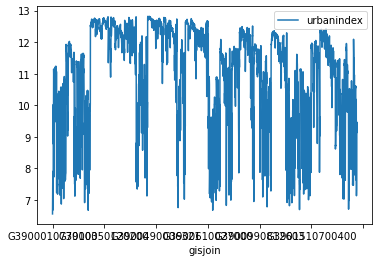

In [12]:
df_Ohio.plot(x='gisjoin', y='urbanindex')

That's not the best visualization, but it does let me see that the bounds of the data are just under 13 and about 6.5 on the urban index. Let's get some statistical information about the urban index. 

In [7]:
df_Ohio[['urbanindex']].describe()

,urbanindex
count,2940.000000
mean,11.031029
std,1.544474
min,6.553258
25%,10.188453
50%,11.499205
75%,12.258868
max,12.822030


It looks like I was right! The min is a little over 6.5 and the max is 12.8. The next step is to split the data into the rural and urban sections and start to get some idea of where these places are. 

## Creating the dataframes of urban and rural areas

In [8]:
#creating a new dataframe that only includes areas with an index of more than 12.78, gives me the top 20 areas. 
df_urbanOH = df_Ohio[df_Ohio.urbanindex>12.28]
df_urbanOH.shape

(706, 8)

In [9]:
#doing the same thing on the rural side. 
df_ruralOH = df_Ohio[df_Ohio.urbanindex<8]
df_ruralOH.shape

(273, 8)

In [10]:
#mapping the urban areas
#find the lat and long of Columbus to center the map
address = 'Columbus, Ohio'

geolocator = Nominatim(user_agent = 'final_project')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Columbus are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Columbus are 39.9622601, -83.0007065.


In [19]:
#using folium and the urban location data to plot the most urban census tracts in Ohio
Ohio_urbanmap = folium.Map(location=[latitude, longitude], zoom_start=7)
for lat, lng in zip(df_urbanOH['lat_tract'], df_urbanOH['long_tract']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Ohio_urbanmap)
#The map will show the top 20 most urban census tracts in Ohio
Ohio_urbanmap

Looking at the map, there are 2 major cities that contain the most urban areas. This is important to know, as we might split the data into the 2 major areas for the venue analysis as another marker of comparison. Now for the rural map! This one should be more spread through the state.  

In [22]:
#using folium and the urban location data to plot the most rural census tracts in Ohio
Ohio_ruralmap = folium.Map(location=[latitude, longitude], zoom_start=7)
for lat, lng in zip(df_ruralOH['lat_tract'], df_ruralOH['long_tract']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Ohio_ruralmap)
#The map will show the top 20 most rural census tracts in Ohio
Ohio_ruralmap

As suspected, the rural areas are more scattered through the state. Now that we have the targeted areas, let's pull some venue information for the rural areas and make sure we have the right areas defined to evaluate. If there are no venues, then a different set of rural areas might have to be considered. 

In [41]:
#initializing FourSquare information
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [11]:
#using the lab function to get the venues in the rural areas 
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
ruralOH_venues = getNearbyVenues(names = df_ruralOH['gisjoin'], latitudes = df_ruralOH['lat_tract'], longitudes = df_ruralOH['long_tract'])

G3900010770100
G3900010770200
G3900010770300
G3900010770400
G3900010770500
G3900010770600
G3900030010100
G3900030010200
G3900030011500
G3900050970100
G3900050970200
G3900050970900
G3900050971000
G3900050971100
G3900070001001
G3900070001101
G3900070001102
G3900070001200
G3900070001301
G3900070001302
G3900070001400
G3900090972600
G3900090972700
G3900090972800
G3900090973500
G3900090973600
G3900110040100
G3900110040500
G3900130010600
G3900130010700
G3900130011000
G3900130011200
G3900150951201
G3900150951202
G3900150951300
G3900150951400
G3900150951500
G3900150951600
G3900150951700
G3900150951800
G3900150951900
G3900190720100
G3900190720400
G3900190720500
G3900190720600
G3900190720700
G3900210010200
G3900210011001
G3900210011505
G3900230002301
G3900230003301
G3900230003302
G3900250040900
G3900250042000
G3900270964300
G3900270964800
G3900270965000
G3900270965100
G3900290951000
G3900290951200
G3900310960900
G3900310961000
G3900310961100
G3900310961800
G3900330974100
G3900330974700
G390037050

In [26]:
ruralOH_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,G3900010770100,38.95705,-83.35256,United States Postal Service,38.951235,-83.403696,Post Office
1,G3900010770100,38.95705,-83.35256,Frank's Deer Urine,38.949499,-83.376850,Hunting Supply
2,G3900010770100,38.95705,-83.35256,State Rt 73 and 32 Intersection,38.975387,-83.338488,Intersection
3,G3900010770100,38.95705,-83.35256,Tomahawk Pizza,38.988899,-83.377884,Pizza Place
4,G3900010770100,38.95705,-83.35256,Locust Grove Dairy Bar,38.991722,-83.377450,American Restaurant
...,...,...,...,...,...,...,...
1752,G3901750938100,40.96162,-83.39985,One Stop Carryout,40.951069,-83.383440,Convenience Store
1753,G3901750938100,40.96162,-83.39985,carey memorial park,40.947762,-83.381727,Park
1754,G3901750938100,40.96162,-83.39985,Wentling Field,40.934023,-83.423176,Football Stadium
1755,G3901750938200,40.80971,-83.41407,Countryside Salon,40.818052,-83.451267,Cosmetics Shop


So in 273 locations, there are 1757 venues. Let's see how many venues per location. 

In [13]:
ruralOH_venue_number = ruralOH_venues.groupby('Neighborhood').count()
ruralOH_venue_number

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
G3900010770100,7,7,7,7,7,7
G3900010770200,3,3,3,3,3,3
G3900010770300,2,2,2,2,2,2
G3900010770400,12,12,12,12,12,12
G3900010770500,5,5,5,5,5,5
...,...,...,...,...,...,...
G3901730021400,5,5,5,5,5,5
G3901730022100,3,3,3,3,3,3
G3901750938000,2,2,2,2,2,2


In [14]:
ruralOH_venue_number[['Venue']].describe()

,Venue
count,266.000000
mean,6.605263
std,6.782206
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,67.000000


Based on the descriptive statistics most of the areas have 6 venues or so. There seem to be some outliers, these are likely commercial areas that will skew the analysis. Let's get rid of anything over 20 venues and see what it looks like. 

In [15]:
df_outliers = ruralOH_venue_number[ruralOH_venue_number.Venue >=20]
df_outliers

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
G3900030010100,25,25,25,25,25,25
G3900150951300,25,25,25,25,25,25
G3900190720500,20,20,20,20,20,20
G3900470925900,59,59,59,59,59,59
G3900510040900,23,23,23,23,23,23
G3900890755300,24,24,24,24,24,24
G3901230050100,67,67,67,67,67,67
G3901270966200,21,21,21,21,21,21
G3901370030300,21,21,21,21,21,21


In [16]:
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3900030010100']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3900150951300']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3900190720500']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3900470925900']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3900510040900']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3900890755300']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3901230050100']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood != 'G3901270966200']
ruralOH_venues = ruralOH_venues[ruralOH_venues.Neighborhood!= 'G3901370030300']

ruralOH_venues.shape

(1472, 7)

In [17]:
ruralOH_venue_number = ruralOH_venues.groupby('Neighborhood').count()
print(ruralOH_venue_number[['Venue']].describe())
print(ruralOH_venues.shape)

            Venue
count  257.000000
mean     5.727626
std      3.830865
min      1.000000
25%      3.000000
50%      5.000000
75%      7.000000
max     19.000000
(1472, 7)


That looks like a more homogenous data set. The standard deviation is much lower than it was previously. 

Now that we have the final rural venue set, let's generate the urban one. For the rural set, the radius was 5km. If we used 5km for the urban set, we would overlap census tracts. So for the urban set, we'll use 1km. So we'll have to redefine the radius for the urban data. 

In [18]:
urbanOH_venues = getNearbyVenues(names = df_urbanOH['gisjoin'], latitudes = df_urbanOH['lat_tract'], longitudes = df_urbanOH['long_tract'], radius = 1000)
urbanOH_venues

G3900350101101
G3900350101102
G3900350101200
G3900350101300
G3900350101400
G3900350101501
G3900350101603
G3900350101700
G3900350101800
G3900350101901
G3900350102101
G3900350102102
G3900350102200
G3900350102300
G3900350102401
G3900350102402
G3900350102700
G3900350102800
G3900350102900
G3900350103100
G3900350103300
G3900350103400
G3900350103500
G3900350103602
G3900350103800
G3900350103900
G3900350104100
G3900350104200
G3900350104300
G3900350104400
G3900350104600
G3900350104800
G3900350104900
G3900350105100
G3900350105300
G3900350105400
G3900350105500
G3900350105602
G3900350105700
G3900350105900
G3900350106100
G3900350106200
G3900350106300
G3900350106400
G3900350106500
G3900350106600
G3900350106800
G3900350106900
G3900350107000
G3900350107701
G3900350107802
G3900350108301
G3900350108400
G3900350108701
G3900350109301
G3900350109701
G3900350109801
G3900350110501
G3900350110801
G3900350110901
G3900350111401
G3900350111500
G3900350111600
G3900350111700
G3900350111800
G3900350111902
G390035011

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,G3900350101101,41.48173,-81.74805,Don's Lighthouse,41.484667,-81.746104,Seafood Restaurant
1,G3900350101101,41.48173,-81.74805,Cocktails,41.480423,-81.747233,Gay Bar
2,G3900350101101,41.48173,-81.74805,McNamara's,41.484222,-81.744119,Dive Bar
3,G3900350101101,41.48173,-81.74805,78th Street Studios,41.484175,-81.739577,Art Gallery
4,G3900350101101,41.48173,-81.74805,Be Fitness,41.485263,-81.756441,Gym / Fitness Center
...,...,...,...,...,...,...,...
19686,G3901530509000,41.07980,-81.49384,Handcraft Cleaners,41.076219,-81.495912,Tailor Shop
19687,G3901530509000,41.07980,-81.49384,Rock Mill Climbing,41.075795,-81.497651,Climbing Gym
19688,G3901530509000,41.07980,-81.49384,KeyBank ATM,41.073802,-81.490199,Bank
19689,G3901530509000,41.07980,-81.49384,Republic Services Akron Recyclery Transfer Sta...,41.078522,-81.485044,Waste Facility


In [40]:
#how many venues are in these neighborhoods? 
urbanOH_venue_number = urbanOH_venues.groupby('Neighborhood').count()
urbanOH_venue_number
print(urbanOH_venue_number[['Venue']].describe())
print(urbanOH_venues.shape)

            Venue
count  706.000000
mean    27.890935
std     24.074901
min      1.000000
25%     10.250000
50%     20.000000
75%     37.000000
max    100.000000
(19691, 7)


Already we can see a stark contrast. With the 1km radius in the urban areas, there are some neighborhoods with 100 venues or more. This should be a good samples to look at types of venues. Recall, we are not really looking at the question of where to build, but what. So we just need a cross section of the urban area and rural area, and the difference in radii will not affect that. 

## Finding the types of venues in each environment

In [21]:
print('There are {} unique urban categories.'.format(len(urbanOH_venues['Venue Category'].unique())))
print('There are {} unique rural categories.'.format(len(ruralOH_venues['Venue Category'].unique())))

There are 448 unique urban categories.
There are 199 unique rural categories.


In [22]:
# one hot encoding
urban_onehot = pd.get_dummies(urbanOH_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
urban_onehot['Neighborhood'] = urbanOH_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [urban_onehot.columns[-1]] + list(urban_onehot.columns[:-1])
urban_onehot = urban_onehot[fixed_columns]

urban_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# one hot encoding
rural_onehot = pd.get_dummies(ruralOH_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rural_onehot['Neighborhood'] = ruralOH_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rural_onehot.columns[-1]] + list(rural_onehot.columns[:-1])
rural_onehot = rural_onehot[fixed_columns]

rural_onehot.head()

,Neighborhood,ATM,Adult Boutique,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,...,Travel & Transport,Tree,Truck Stop,Vacation Rental,Video Store,Waterfall,Wine Bar,Wine Shop,Winery,Women's Store
0,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,G3900010770100,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Totaling Up the Types of Venues

After counting up the number of venues in the urban and rural datasets, this code creates new dataframes that just contain the total venues in each category. 

In [25]:
rural_total = rural_onehot
rural_total.loc['Total']=rural_onehot.sum()
rural_total


,Neighborhood,ATM,Adult Boutique,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,...,Travel & Transport,Tree,Truck Stop,Vacation Rental,Video Store,Waterfall,Wine Bar,Wine Shop,Winery,Women's Store
0,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,G3900010770100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,G3900010770100,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,G3901750938100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1754,G3901750938100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1755,G3901750938200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1756,G3901750938200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#dropping the Neighborhood information at this point because I just care about venue type. 
rural_total = rural_total.drop(columns = ['Neighborhood'])

In [27]:
#getting rid of all the rows except for the total row
rural_total = rural_total[rural_total['American Restaurant']==62]
rural_total

,ATM,Adult Boutique,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,...,Travel & Transport,Tree,Truck Stop,Vacation Rental,Video Store,Waterfall,Wine Bar,Wine Shop,Winery,Women's Store
Total,6,2,4,62,4,4,3,1,6,2,...,2,4,1,2,2,1,1,2,4,1


In [28]:
#repeating the process for the urban data 
urban_total = urban_onehot
urban_total.loc['Total']=urban_onehot.sum()
urban_total = urban_total.drop(columns = ['Neighborhood'])
urban_total





,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
urban_total = urban_total[urban_total['American Restaurant']==453]
urban_total

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
Total,81,84,23,4,1,7,6,1,453,7,...,1,7,11,69,35,3,83,43,68,5


## Visualizing the data


Now that I know what kinds of venues are in urban and rural areas of Ohio, it's time to visualize the data and make a recommendation for development of both the farmland and the re-emerging urban area. 

In [30]:
urban_total = urban_total.transpose()
rural_total = rural_total.transpose()

In [31]:
#sorting the data by most prevalent venue
urban_total = urban_total.sort_values(by = ['Total'], ascending = False)
#resetting the index to be able to name the columns
urban_total = urban_total.reset_index(drop = False)
urban_total.columns = ('Venue Type', 'Urban Total')
urban_total.head(15)

,Venue Type,Urban Total
0,Pizza Place,890
1,Bar,806
2,Sandwich Place,614
3,Fast Food Restaurant,551
4,Coffee Shop,487
5,Discount Store,485
6,Park,456
7,American Restaurant,453
8,Bank,417
9,Convenience Store,397


In [32]:

urban_total.columns = ("Venue Type", 'Urban Total')

urban_total.head(15)

,Venue Type,Urban Total
0,Pizza Place,890
1,Bar,806
2,Sandwich Place,614
3,Fast Food Restaurant,551
4,Coffee Shop,487
5,Discount Store,485
6,Park,456
7,American Restaurant,453
8,Bank,417
9,Convenience Store,397


In [33]:
rural_total = rural_total.sort_values(by = ['Total'], ascending = False)

rural_total.head(15)

,Total
Discount Store,97
Pizza Place,84
American Restaurant,62
Sandwich Place,59
Post Office,58
Campground,57
Construction & Landscaping,56
Gas Station,52
Bar,42
Fast Food Restaurant,42


In [34]:
rural_total = rural_total.reset_index(drop = False)
rural_total.columns = ('Venue Type', 'Rural Total')
rural_total.head()

,Venue Type,Rural Total
0,Discount Store,97
1,Pizza Place,84
2,American Restaurant,62
3,Sandwich Place,59
4,Post Office,58


In [35]:
#need named columns to be able to merge the dataframes and compare them
venue_compare = rural_total.merge(urban_total)
venue_compare = venue_compare.head(30)
venue_compare

,Venue Type,Rural Total,Urban Total
0,Discount Store,97,485
1,Pizza Place,84,890
2,American Restaurant,62,453
3,Sandwich Place,59,614
4,Post Office,58,22
5,Campground,57,1
6,Construction & Landscaping,56,95
7,Gas Station,52,293
8,Bar,42,806
9,Fast Food Restaurant,42,551


In [36]:
#setting the index back to venue type for graphing
venue_compare = venue_compare.set_index('Venue Type')
venue_compare

,Rural Total,Urban Total
Venue Type,,
Discount Store,97,485
Pizza Place,84,890
American Restaurant,62,453
Sandwich Place,59,614
Post Office,58,22
Campground,57,1
Construction & Landscaping,56,95
Gas Station,52,293
Bar,42,806


In [37]:
#finding the total numnber of venues in this subset to be able to normalize the data. 
df = venue_compare.sum()
df

Rural Total    1052
Urban Total    7629
dtype: int64

In [38]:
#manually dividing the data to create a normal dataframe
venue_compare_normal = venue_compare.divide([1052,7629], axis = 'columns')
venue_compare_normal
#venue_compare_normal= venue_compare_normal.drop(columns = ['index'])


,Rural Total,Urban Total
Venue Type,,
Discount Store,0.092205,0.063573
Pizza Place,0.079848,0.116660
American Restaurant,0.058935,0.059379
Sandwich Place,0.056084,0.080482
Post Office,0.055133,0.002884
Campground,0.054183,0.000131
Construction & Landscaping,0.053232,0.012452
Gas Station,0.049430,0.038406
Bar,0.039924,0.105649


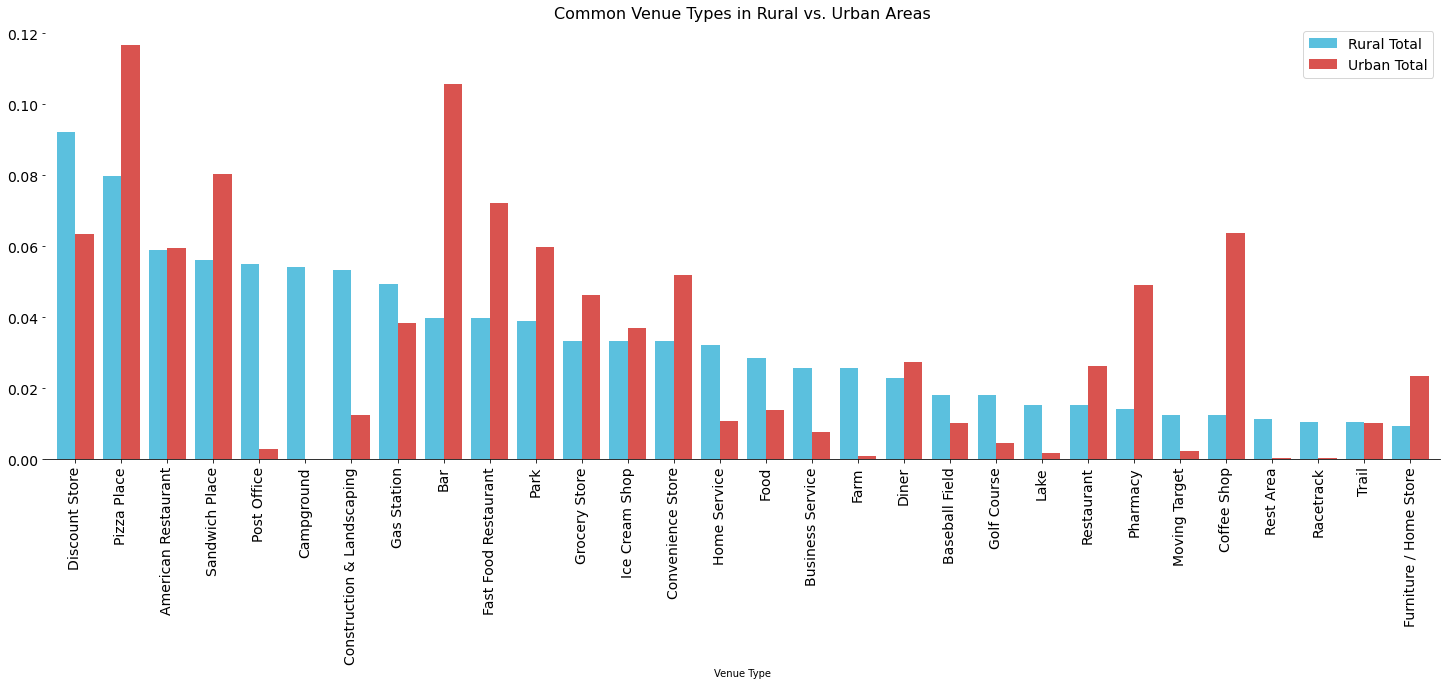

In [39]:
#graphing the comparative values 
bargraph = venue_compare_normal.plot(kind = 'bar', figsize = (25,8), width = .8, color = ('#5bc0de', '#d9534f'), fontsize = 14)
bargraph.set_title("Common Venue Types in Rural vs. Urban Areas", fontsize = 16)
bargraph.legend(fontsize = 14)
bargraph.spines['top'].set_visible(False)
bargraph.spines['right'].set_visible(False)
bargraph.spines['left'].set_visible(False)

#for p in bargraph.patches:
    #bargraph.annotate("{:.0%}".format(p.get_height()),
                #xy=(p.get_x()+0.02, p.get_height()+0.01))

In conclusion: If a developer had a tract of rural farmland in Ohio, it wouldn't be a bad plan to put a pizza place or a gas station on it. In urban areas, a bar would be your best bet. Or, pizza again! It appears that whether urban or rural, Ohio loves pizza! 